# Li et al., 2015 - A DataJoint example

The data and results presented in this notebook pertain to the paper:

>Nuo Li, Tsai-Wen Chen, Zengcai V. Guo, Charles R. Gerfen & Karel Svoboda. "A motor cortex circuit for motor planning and movement" (2015) Nature (https://dx.doi.org/10.1038/nature14178)

This study investigated in detail the cortical circuits within the mouse motor cortex associated with movement planning, specifically the preparatory activity to ipsi- or contralateral movements. Extracellular electrophysiology recordings, coupled with cellular imaging and optogenetic perturbation, were performed on mouse anterior lateral motor cortex (ALM), during tactile decision task. The study reported unbiased laterality characteristic of layer 5 ALM neurons.

This notebook provide demonstrations of working with a **DataJoint** data pipeline in querying data, apply data conditioning and reproduce some key figures in the paper. As a validation of complete ingestion of the original data into DataJoint, figures 2b, 2c, and extended figure 2 will be reproduced in this example.

## About the data

The pipeline contains the extracellular neurophysiology data set and behavior data set described in this study. The orignal data, in MATLAB (.mat) format, had been ingested into a DataJoint data pipeline (data pipeline schema is given below).
The behavioral data includes detailed description of the trial structure (e.g. trial timing, trial instruction, trial response) as well as the lick traces (both for left and right licks).

Data are also exported into NWB 2.0 format. The code used for performing NWB export can be found [here](../scripts/datajoint_to_nwb.py).

In [1]:
# import necessary Python packages including DataJoint

%matplotlib inline
import os
os.chdir('..')
import datajoint as dj
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

from pipeline import lab, experiment, ephys, psth, virus
from pipeline.plot import unit_characteristic_plot, unit_psth

Connecting root@localhost:3306


In [2]:
import warnings
warnings.filterwarnings('ignore')

## The architecture of this data pipeline

This data pipeline is comprised of three core *components*:

+ **subject**: the meta information about the animal, e.g. genetic information, virus injection, etc.
+ **acquisition**: the organization of the experiment - session acquisition, trial structure, behavior data
+ **electrophysiology**: extracellular recordings, as well as results of spike sorting

In DataJoint, related tables are organized together into a **schema**, and a data pipeline typically consists of tables across multiple schemas connected to each other.

### Subject

`subject` schema contains various tables representing information and meta-information about the experimental animals, as well as information about genetic backgrounds and virus injected for the experiment. The DataJoint *Diagram* below shows all tables found inside the `subject` schema.

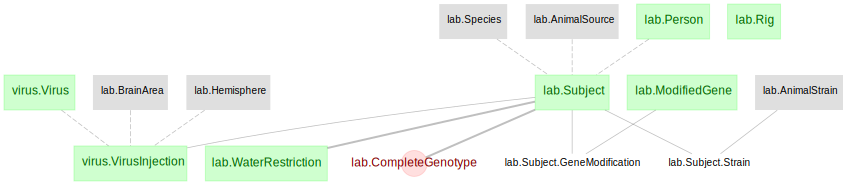

In [3]:
dj.Diagram(lab.Subject) + 1 - 1 - dj.Diagram(experiment)

For example, `Subject` table contains information about each and every mouse in the experiment, capturing information such as unique subject ID and animal sourcce.

In [4]:
lab.Subject()

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,species,animal_source
210861,None,None,2013-03-11,M,Mus musculus,GENSAT
210862,None,None,2013-03-11,M,Mus musculus,GENSAT
210863,None,None,2013-03-11,M,Mus musculus,GENSAT
214427,None,None,None,M,Mus musculus,GENSAT
214429,None,None,None,M,Mus musculus,GENSAT
214430,None,None,None,F,Mus musculus,GENSAT
218453,None,None,2013-06-04,M,Mus musculus,GENSAT


### Experiment and behavior

Information pertaining to conducting the experiment as well as data and meta-data acquired during the experiment (except for electrophysiology) are found among three schemas: `acquisition`, `stimulation` and `behavior`. Below, tables across all three schemas are depicted in the DataJoint Diagram.

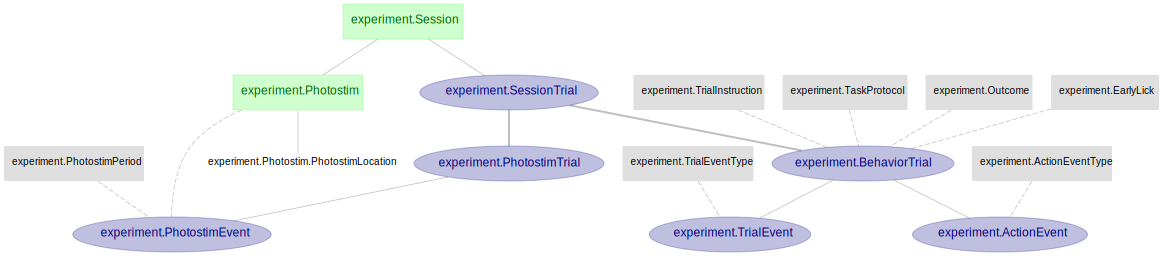

In [9]:
(dj.ERD(experiment.SessionTrial) - 1 
 + experiment.Photostim.PhotostimLocation
 + (dj.ERD(experiment.BehaviorTrial) + 1 - 1) 
 + (dj.ERD(experiment.PhotostimTrial) + 1 - 1)) 

`Session` tables contains information about individual experiment session.

In [10]:
experiment.Session()

subject_id institution 6 digit animal ID,session session number,session_date,username,rig
210861,1,2013-07-01,Nuo Li,None
210861,2,2013-07-02,Nuo Li,None
210861,3,2013-07-03,Nuo Li,None
210862,1,2013-06-26,Nuo Li,None
210862,2,2013-06-27,Nuo Li,None
210862,3,2013-06-28,Nuo Li,None
210863,1,2013-06-26,Nuo Li,None


`Trial` table (found as part table of `TrialSet`) contains information about each trial.

In [11]:
experiment.BehaviorTrial * experiment.PhotostimTrial 

subject_id institution 6 digit animal ID,session session number,trial trial number,task task type,task_protocol task protocol,trial_instruction,early_lick,outcome
210861,1,12,audio delay,1,left,early,miss
210861,1,15,audio delay,1,right,early,hit
210861,1,21,audio delay,1,left,early,miss
210861,1,25,audio delay,1,right,early,hit
210861,1,29,audio delay,1,left,early,hit
210861,1,33,audio delay,1,left,early,hit
210861,1,39,audio delay,1,left,early,hit


### Extracellular Electrophysiology

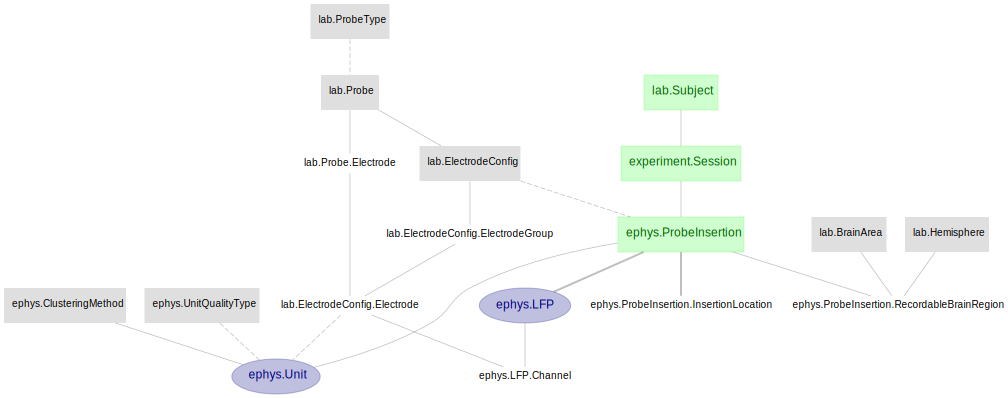

In [12]:
(dj.Diagram(experiment.Session) + lab.Subject + ephys.ProbeInsertion
 + (dj.Diagram(ephys.Unit) - 1) + lab.Probe + lab.ProbeType + lab.ElectrodeConfig
 + lab.BrainArea + lab.Hemisphere + ephys.ProbeInsertion.InsertionLocation
 + ephys.ProbeInsertion.RecordableBrainRegion
 + ephys.LFP + ephys.LFP.Channel)

As an example, `ephys.Unit` table contains information about each and every sorted units and their associated spike trains (in the form of unit spike times).

In [13]:
ephys.Unit()

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_name user friendly name,electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform spike waveform (#spike x #time)
210861,1,1,manual,1,None,good,A4x8-5mm-100-200-177,silicon32,0,1,-3700.0,1393.23,=BLOB=,nan,nan,=BLOB=
210861,1,1,manual,2,None,good,A4x8-5mm-100-200-177,silicon32,0,6,-3700.0,893.23,=BLOB=,nan,nan,=BLOB=
210861,1,1,manual,3,None,good,A4x8-5mm-100-200-177,silicon32,0,9,-3900.0,1393.23,=BLOB=,nan,nan,=BLOB=
210861,1,1,manual,5,None,good,A4x8-5mm-100-200-177,silicon32,0,9,-3900.0,1393.23,=BLOB=,nan,nan,=BLOB=
210861,1,1,manual,6,None,good,A4x8-5mm-100-200-177,silicon32,0,10,-3900.0,1293.23,=BLOB=,nan,nan,=BLOB=
210861,1,1,manual,7,None,good,A4x8-5mm-100-200-177,silicon32,0,11,-3900.0,1193.23,=BLOB=,nan,nan,=BLOB=
210861,1,1,manual,8,None,good,A4x8-5mm-100-200-177,silicon32,0,12,-3900.0,1093.23,=BLOB=,nan,nan,=BLOB=


## Reproduced analysis and figures  

Below, we reproduce selected figures from [Li et al., 2015](https://dx.doi.org/10.1038/nature14178), demonstrating the usage of the DataJoint pipeline in retrieving specifically desired data.

## Single unit PSTH - Figure 2b

This figure shows the raster plot of spikes grouped in **ipsi** (red) and **contra** (blue) trials, along with the trial-averaged spike PSTH, for several representative units.

To extract the relevant subset of data and plot, we will use the built-in `plot_unit_psth()` functions, which can be called with any unit passed in as argument. 

The implementation detail of `plot_unit_psth()` can be found [here](../pipeline/plot/unit_psth.py), in short, this function performs the following steps:
1. Given a unit, search all behavior trials where this unit was recording on
2. Split into groups of **left** trials and **right** trials, based on the location of the specified unit, match **left**/**right** trials into **ipsi**/**contra** trial appropriately
3. Extract trial-segmented spike times of the unit, per trial, time-locked to `go_cue`
4. Generate trial-averaged PSTH
5. Plot spike raster and spike PSTH

#### Here, we first select a set of sample neurons

In [14]:
units = ephys.Unit & [{'subject_id': 218457, 'session': 4, 'unit': 11},
                      {'subject_id': 219248, 'session': 2, 'unit': 12},  
                      {'subject_id': 219037, 'session': 2, 'unit': 5},
                      {'subject_id': 219031, 'session': 2, 'unit': 17},
                      {'subject_id': 210862, 'session': 2, 'unit': 29},
                      {'subject_id': 210863, 'session': 2, 'unit': 10},
                      {'subject_id': 210863, 'session': 1, 'unit': 10},
                      {'subject_id': 219033, 'session': 5, 'unit': 1},
                      {'subject_id': 219036, 'session': 5, 'unit': 13}]

#### Then we evoke the `plot_unit_psth()` function to plot for each unit

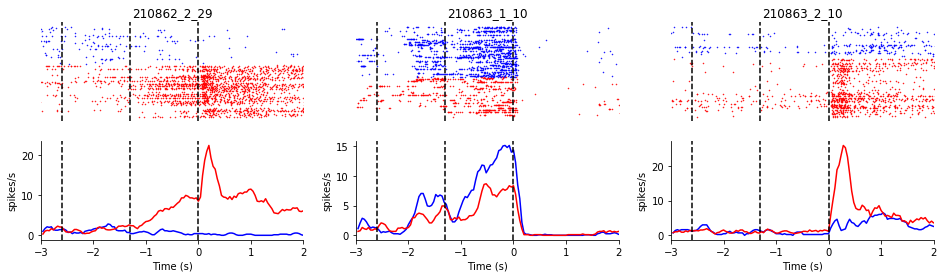

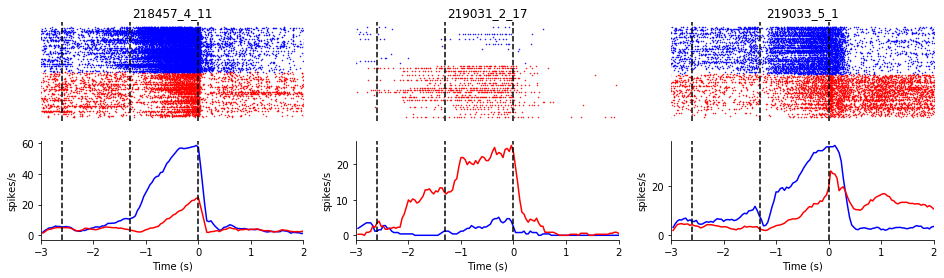

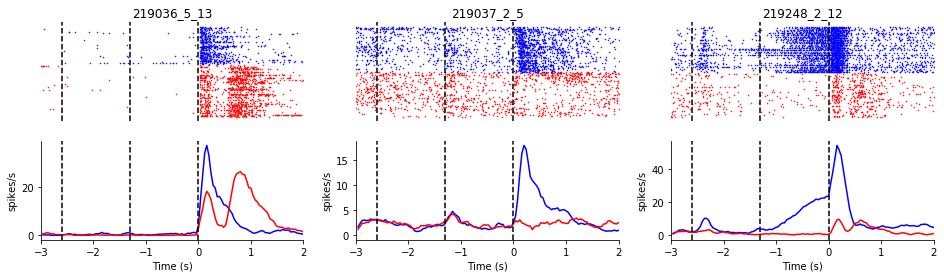

In [15]:
unit_keys = units.fetch('KEY')
ax_per_row = 3
for offset in np.arange(0, len(units), ax_per_row):
    fig, axes = plt.subplots(2, ax_per_row, figsize=(16, 4))
    for axs, u in zip(axes.T, unit_keys[offset: offset + ax_per_row]):
        unit_psth.plot_unit_psth(u, axs=axs,
                                 title='_'.join([str(u['subject_id']), str(u['session']), str(u['unit'])]))

## Single unit PSTH - Extended Data Figure 2
Similarly, for extended data Figure 2a - an extended set of neurons are selected here for the spike-raster and psth plots

In [16]:
units = ephys.Unit & [{'subject_id': 214430, 'session': 2, 'unit': 4},
                      {'subject_id': 218457, 'session': 1, 'unit': 1},
                      {'subject_id': 210863, 'session': 1, 'unit': 7},
                      {'subject_id': 219033, 'session': 4, 'unit': 5},
                      {'subject_id': 210862, 'session': 2, 'unit': 23},  
                      {'subject_id': 210861, 'session': 2, 'unit': 6},
                      {'subject_id': 210863, 'session': 1, 'unit': 11},
                      {'subject_id': 218457, 'session': 3, 'unit': 3},
                      {'subject_id': 219031, 'session': 5, 'unit': 3},
                      {'subject_id': 210863, 'session': 2, 'unit': 10},
                      {'subject_id': 219033, 'session': 3, 'unit': 5},
                      {'subject_id': 218457, 'session': 4, 'unit': 14},
                      {'subject_id': 219247, 'session': 1, 'unit': 4},
                      {'subject_id': 219248, 'session': 2, 'unit': 12},
                      {'subject_id': 210862, 'session': 2, 'unit': 4},                   
                      {'subject_id': 219248, 'session': 1, 'unit': 11},
                      {'subject_id': 219031, 'session': 5, 'unit': 4},
                      {'subject_id': 219031, 'session': 2, 'unit': 14},
                      {'subject_id': 210863, 'session': 3, 'unit': 34},
                      {'subject_id': 219030, 'session': 5, 'unit': 8}]

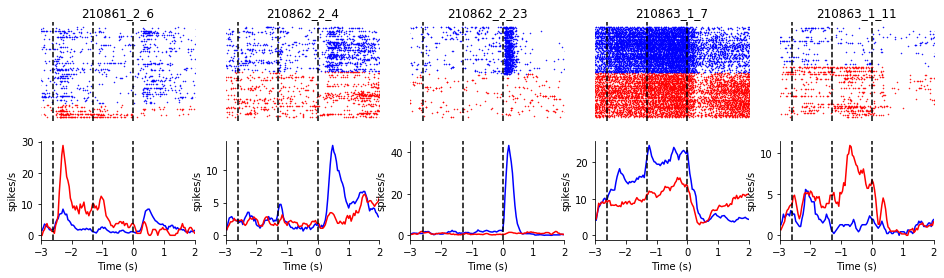

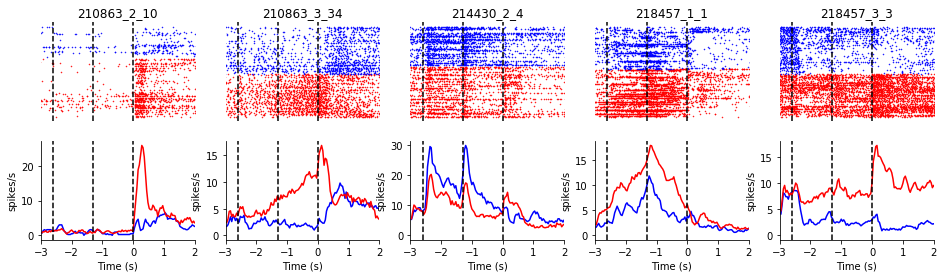

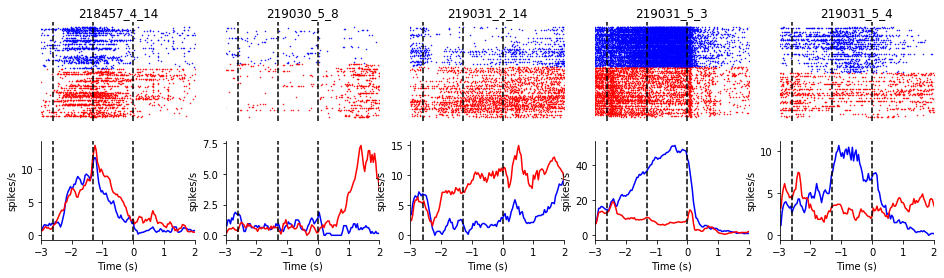

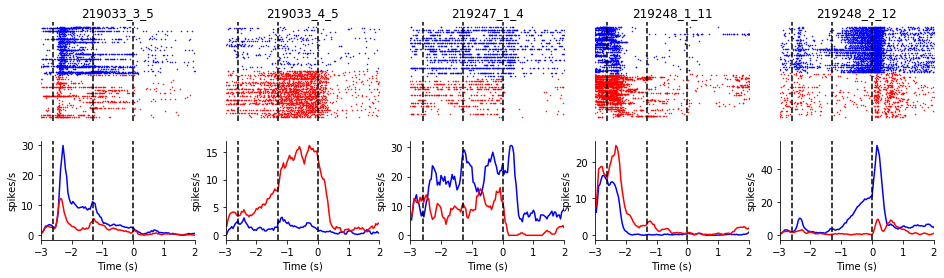

In [17]:
ax_per_row = 5
for offset in np.arange(0, len(units), ax_per_row):
    fig, axes = plt.subplots(2, ax_per_row, figsize=(16, 4))
    for axs, u in zip(axes.T, units.fetch('KEY', offset=offset, limit=ax_per_row)):
        unit_psth.plot_unit_psth(u, axs=axs,
                                 title='_'.join([str(u['subject_id']), str(u['session']), str(u['unit'])]))

## Group-level unit PSTH with selectivity - Figure 2c

This figure shows the averaged PSTH differences between ipsi and contra trials per unit, for all units categorized as **ipsi** selective or **contra** selective. 

Based on the spiking activity, each unit is classified as `ipsi-selective`, `contra-selective` or `non-selective`. 

A unit is deemed **ipsi** selective if its spike rates during **ipsi** trials are significantly higher than that during **contra** trials, and vice versa (refer to the paper for more details). 

This selectivity characteristic is automatically computed in this DataJoint pipeline, and stored in the `psth.PeriodSelectivity` and `psth.UnitSelectivity` tables (see the follow diagram for a recap of the table structure).

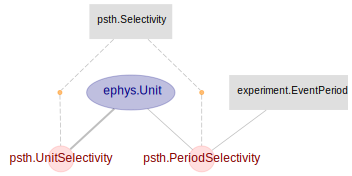

In [18]:
(dj.Diagram(psth.PeriodSelectivity) - 1) + psth.UnitSelectivity

For each group of **contra** vs. **ipsi** selective units, the units are further sorted in to three categories:
+ unit exibited selectivity during **sample** or **delay** and not **response** period
+ unit exibited selectivity during **sample** or **delay** and **response** period
+ unit exibited selectivity only during **response** period

Here, we select all units passing the restriction criteria:
+ located in left M2 area
+ `Pyramidal` cell type
+ only selective units

In [20]:
# left M2 region
units = (ephys.Unit & (ephys.ProbeInsertion.RecordableBrainRegion & {'brain_area': 'M2', 'hemisphere': 'left'}))

In [21]:
# Pyramidal cell type, selective unit only
units = units * ephys.UnitCellType * psth.UnitSelectivity & 'cell_type = "Pyr"'

We plot Figure 2C by calling a built-in analysis and plot function `plot_selectivity_sorted_stacked_contra_ipsi_psth()` and pass in a group of preselected units. 

The function's implementation can be found [here](../pipeline/plot/unit_characteristic_plot), in short, it performs:
1. For all specified units, split into 2 groups: **ipsi** and **contra** selective (ignore **non-selective** units)
2. In each group, further categorize into selective unit during:
    + **sample** or **delay** and not **response** period
    + **sample** or **delay** and **response** period
    + only **response** period
3. For each unit, compute the PSTH differences between ipsi and contra trials
4. Plot the PSTH differences for all units

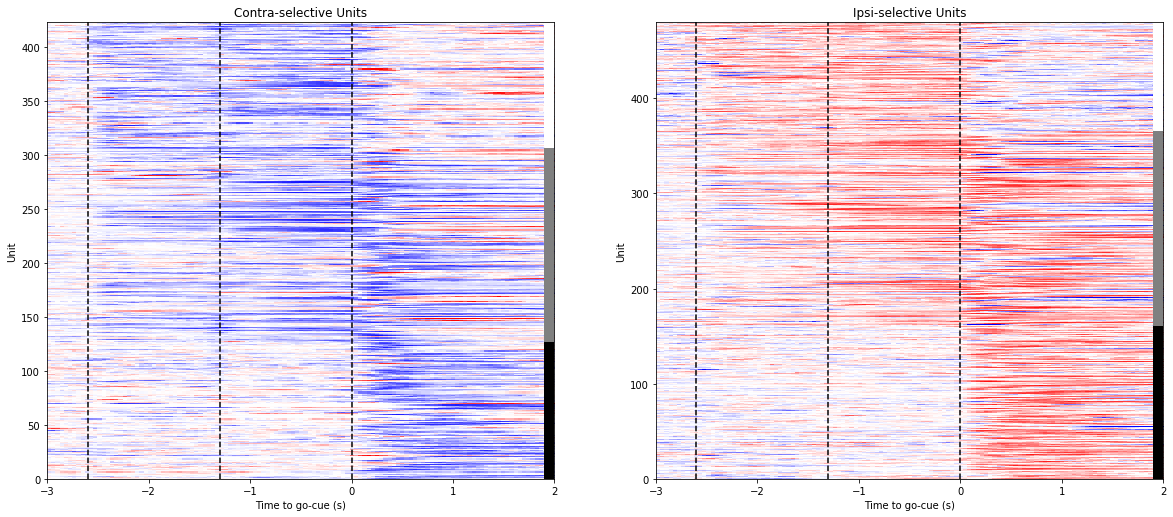

In [22]:
unit_characteristic_plot.plot_selectivity_sorted_stacked_contra_ipsi_psth(units)